In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [2]:
import importlib
import utils.data_processing as data_processing
importlib.reload(data_processing)
from utils.data_processing import get_dataloaders, set_seed, save_output, get_df

In [3]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [4]:
df = get_df()

In [5]:
num_subjects = df["subject"].nunique()
print("Number of unique subjects:", num_subjects)

Number of unique subjects: 1384


In [6]:
# same as sklearn 

seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

subj_onehot = pd.get_dummies(df['subject'], prefix='subj')
df_static = pd.concat([df[static_features], subj_onehot], axis=1)

X_seq = df[seq_features]
X_static = df_static
y = df[target]

# split based on subjects
subjects = df['subject'].unique()
train_subj, test_subj = train_test_split(subjects, test_size=0.2, random_state=42)

train_mask = df['subject'].isin(train_subj)
test_mask  = df['subject'].isin(test_subj)

X_seq_train = df.loc[train_mask, seq_features]
X_seq_test  = df.loc[test_mask, seq_features]

X_static_train = df_static.loc[train_mask]
X_static_test  = df_static.loc[test_mask]

y_train = y[train_mask]
y_test  = y[test_mask]

print("--- Feature Data (X) ---")
print(X_seq.head())
print(X_static.head())
print("\n--- Target Data (y) ---")
print(y.head())


# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()


# separate numeric static vs one-hot
onehot_cols = [c for c in X_static.columns if c.startswith('subj_')]

scaler = StandardScaler()

X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)

# X_static_train = scaler.fit_transform(X_static_train)
# X_static_test = scaler.transform(X_static_test)
X_static_train_num = scaler.fit_transform(X_static_train[static_features])
X_static_test_num  = scaler.transform(X_static_test[static_features])

# keep one-hot untouched
X_static_train_oh = X_static_train[onehot_cols].to_numpy()
X_static_test_oh  = X_static_test[onehot_cols].to_numpy()

# combine back
X_static_train = np.hstack([X_static_train_num, X_static_train_oh])
X_static_test  = np.hstack([X_static_test_num, X_static_test_oh])



--- Feature Data (X) ---
     r0   c0    r1   c1    r2   c2    r3   c3
0  42.0  0.0  45.0  1.0  42.0  1.0  18.0  1.0
1  67.0  0.0  57.0  1.0  56.0  0.0  50.0  1.0
2  37.0  1.0  48.0  0.0  23.0  0.0  39.0  1.0
3  58.0  1.0  51.0  0.0  28.0  0.0  47.0  1.0
4   4.0  1.0  30.0  0.0  11.0  1.0  37.0  0.0
   gameLength  uc  subj_0  subj_1  subj_100  subj_1000  subj_1001  \
0           6   1    True   False     False      False      False   
1           6   0    True   False     False      False      False   
2           6   0    True   False     False      False      False   
3           1   0    True   False     False      False      False   
4           1   0    True   False     False      False      False   

   subj_1001.0_TMS  subj_1002  subj_1002.0_TMS  ...  subj_990  subj_991  \
0            False      False            False  ...     False     False   
1            False      False            False  ...     False     False   
2            False      False            False  ...     Fal

In [7]:
SEQ_LEN = seq_features.__len__() // 4 
print(f"SEQ_LEN: {SEQ_LEN}")
STATIC_LEN = X_static_train.shape[1]
print(f"STATIC_LEN: {STATIC_LEN}")

SEQ_LEN: 2
STATIC_LEN: 1386


In [8]:
feature_order_test = np.array(seq_features).reshape(-1, 4, SEQ_LEN)
print(feature_order_test)

[[['r0' 'c0']
  ['r1' 'c1']
  ['r2' 'c2']
  ['r3' 'c3']]]


In [9]:
print(X_seq_train.shape)
print(X_seq_test.shape)
print(type(X_seq_train))
print(type(y_train))

(136652, 8)
(34333, 8)
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [10]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
print(X_seq_train.shape)
print(type(X_seq_train))
print(X_seq_train[0])
X_seq_test = X_seq_test.reshape(-1, 4, SEQ_LEN)
print(X_seq_test.shape)
print(type(X_seq_test))

(136652, 4, 2)
<class 'numpy.ndarray'>
[[-0.44340398 -1.03825727]
 [-0.26885783  0.99938183]
 [-0.49591546  1.03400207]
 [-1.84556152  1.00375379]]
(34333, 4, 2)
<class 'numpy.ndarray'>


convert to tensor for pytorch

In [11]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [12]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [13]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_idx = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_idx = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = X_seq_test_tensor[h1_idx]
X_seq_test_h6 = X_seq_test_tensor[h6_idx]

X_static_test_h1 = X_static_test_tensor[h1_idx]
X_static_test_h6 = X_static_test_tensor[h6_idx]

y_test_h1 = y_test_tensor[h1_idx]
y_test_h6 = y_test_tensor[h6_idx]


In [14]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [15]:
from utils.models import (
    RNN,
    LSTM,
    GRU,
    TinyGRU,
    TransformerEncoderPositionalEncoding,
    SelfAttentionOnly,
)
from utils.train_eval import train_and_evaluate

# running experiment

In [16]:
model_dict = {
    "RNN": RNN(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
    "LSTM": LSTM(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
    "GRU": GRU(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
    "TinyGRU": TinyGRU(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
    "Transformer": TransformerEncoderPositionalEncoding(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
    "Self-Attention": SelfAttentionOnly(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
    # "TinyAttentionNoProj": TinyAttentionNoProj(SEQ_LEN, static_input_size=STATIC_LEN).to(device),
}

In [17]:
epochs = 100
test_loaders = (test_loader, test_loader_h1, test_loader_h6)
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train_and_evaluate(model, train_loader, test_loaders, criterion, optimizer, device, epochs=epochs)
    model_dict[model_name] = {
        "model": model,
        **history
    }



Training model: RNN
Epoch 1: Loss: 0.5110 | overall: 0.7683 | H1 0.8058 | H6 0.7309
Epoch 10: Loss: 0.5207 | overall: 0.7566 | H1 0.7994 | H6 0.7138
Early stopping triggered: epoch 10 best_loss 0.5060

Training model: LSTM
Epoch 1: Loss: 0.5089 | overall: 0.7726 | H1 0.8135 | H6 0.7317
Epoch 10: Loss: 0.5222 | overall: 0.7551 | H1 0.8010 | H6 0.7092
Early stopping triggered: epoch 11 best_loss 0.5019

Training model: GRU
Epoch 1: Loss: 0.5038 | overall: 0.7685 | H1 0.8103 | H6 0.7268
Early stopping triggered: epoch 7 best_loss 0.5038

Training model: TinyGRU
Epoch 1: Loss: 0.5331 | overall: 0.7496 | H1 0.7819 | H6 0.7173
Epoch 10: Loss: 0.5292 | overall: 0.7430 | H1 0.7945 | H6 0.6915
Early stopping triggered: epoch 10 best_loss 0.5259

Training model: Transformer
Epoch 1: Loss: 0.5109 | overall: 0.7617 | H1 0.7981 | H6 0.7252
Early stopping triggered: epoch 8 best_loss 0.5032

Training model: Self-Attention
Epoch 1: Loss: 0.5077 | overall: 0.7694 | H1 0.8105 | H6 0.7283
Early stoppin

In [18]:

save_output(model_dict, "output_individual")

Saved model results to output_individual.json


# age and gender

In [19]:
def get_subject_predictions(model, loader, subj_ids, criterion, device):
    model.eval()
    all_preds, all_labels, all_subj = [], [], []
    with torch.no_grad():
        for i, (seq_inputs, static_inputs, labels) in enumerate(loader):
            idx = range(i*loader.batch_size, i*loader.batch_size + len(labels))
            subj_batch = [subj_ids[j] for j in idx]
            
            seq_inputs, static_inputs, labels = seq_inputs.to(device), static_inputs.to(device), labels.to(device)
            logits = model(seq_inputs, static_inputs)
            preds = logits.argmax(dim=1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_subj.extend(subj_batch)

    import pandas as pd
    return pd.DataFrame({
        "subject": all_subj,
        "pred": all_preds,
        "label": all_labels
    })

In [20]:
pred_df = get_subject_predictions(model, test_loader, df.loc[test_mask, "subject"].tolist(), criterion, device)
pred_df["correct"] = (pred_df["pred"] == pred_df["label"]).astype(int)

pred_df["gameLength"] = df.loc[test_mask, "gameLength"].values
pred_df["age"] = df.loc[test_mask, "age"].values
pred_df["gender"] = df.loc[test_mask, "gender"].values

# per-subject accuracies
subj_acc = pred_df.groupby("subject")["correct"].mean().rename("acc_overall")
acc_h1 = pred_df.loc[pred_df["gameLength"]==1].groupby("subject")["correct"].mean().rename("acc_h1")
acc_h6 = pred_df.loc[pred_df["gameLength"]==6].groupby("subject")["correct"].mean().rename("acc_h6")

subj_df = pd.concat([subj_acc, acc_h1, acc_h6], axis=1)
subj_df["delta_h6_h1"] = subj_df["acc_h6"] - subj_df["acc_h1"]

age_map = pred_df.groupby("subject")["age"].first()
subj_df = subj_df.join(age_map)

gender_map = {0: "F", 1: "M"}
gender_map_subj = pred_df.groupby("subject")["gender"].first().map(gender_map)
subj_df = subj_df.join(gender_map_subj.rename("gender"))

print(subj_df)

            acc_overall    acc_h1    acc_h6  delta_h6_h1  age gender
subject                                                             
1001           0.828125  0.765625  0.890625     0.125000   72      F
1002.0_TMS     0.781250  0.750000  0.812500     0.062500   26      F
1003           0.750000  0.890625  0.609375    -0.281250   65      F
1005.0_TMS     0.718750  0.725000  0.712500    -0.012500   32      M
1007.0_TMS     0.743750  0.800000  0.687500    -0.112500   20      F
...                 ...       ...       ...          ...  ...    ...
983            0.718750  0.703125  0.734375     0.031250   69      M
984            0.593750  0.609375  0.578125    -0.031250   20      F
986            0.820312  0.890625  0.750000    -0.140625   73      M
987            0.625000  0.750000  0.500000    -0.250000   73      F
999            0.679688  0.828125  0.531250    -0.296875   68      M

[277 rows x 6 columns]


## age

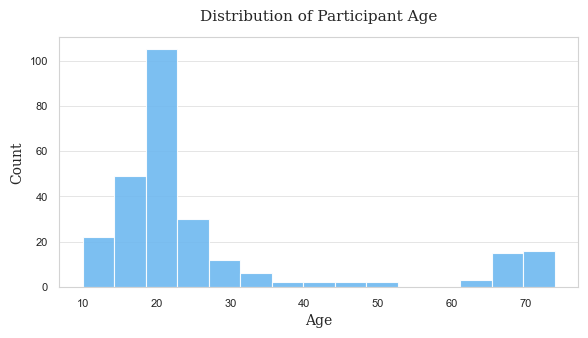

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Data prep ---
subj_df["age"] = subj_df["age"].replace(-99, np.nan)
ages = subj_df["age"].dropna()

# --- Local style (same as other figures) ---
sns.set_theme(style="white", font="serif", context="paper", font_scale=1.1)
PLOT_COLOR = "#6eb8f0"
SPINE_COLOR = "#D3D3D3"
GRID_COLOR = "#E0E0E0"

# --- Figure ---
fig, ax = plt.subplots(figsize=(6, 3.5))

# --- Histogram ---
ax.hist(ages, bins=15, color=PLOT_COLOR, edgecolor="white", alpha=0.9)

# --- Labels and title ---
ax.set_xlabel("Age", fontfamily="serif", fontsize=10)
ax.set_ylabel("Count", fontfamily="serif", fontsize=10)
ax.set_title("Distribution of Participant Age", fontfamily="serif", fontsize=11, pad=12)

# --- Tick labels ---
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily("sans-serif")
    label.set_fontsize(8)

# --- Styling ---
for spine in ax.spines.values():
    spine.set_color(SPINE_COLOR)
    spine.set_linewidth(0.8)

ax.grid(True, axis="y", color=GRID_COLOR, linestyle="-", linewidth=0.6)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()


In [22]:
bins = [10, 20, 30, 40, 50, 60, 70, 80]
labels = [f"{bins[i]}-{bins[i+1]}" for i in range(len(bins)-1)]

subj_df["age_group"] = pd.cut(subj_df["age"], bins=bins, labels=labels, right=False)

age_group_acc = subj_df.groupby("age_group")[["acc_h1", "acc_h6"]].mean().reset_index()

C:\Users\91486\AppData\Local\Temp\ipykernel_16124\1692610687.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_acc = subj_df.groupby("age_group")[["acc_h1", "acc_h6"]].mean().reset_index()


In [37]:
def plot_age_group_accuracy(age_group_acc):
    # --- Style (same as other figures) ---
    sns.set_theme(style="white", font="serif", context="paper", font_scale=1.1)
    PLOT_COLORS = ["#ff7e73","#6eb8f0"]  # H1 / H6
    SPINE_COLOR = "#D3D3D3"
    GRID_COLOR = "#E0E0E0"

    fig, ax = plt.subplots(figsize=(6, 3.5))

    # --- Lines ---
    ax.plot(
        age_group_acc["age_group"], age_group_acc["acc_h1"],
        marker="o", color=PLOT_COLORS[0], linewidth=1.4,
        label="H1"
    )
    ax.plot(
        age_group_acc["age_group"], age_group_acc["acc_h6"],
        marker="o", color=PLOT_COLORS[1], linewidth=1.4,
        label="H6"
    )

    # --- Labels & title ---
    ax.set_xlabel("Age Group", fontfamily="serif", fontsize=10)
    ax.set_ylabel("Average Accuracy", fontfamily="serif", fontsize=10)
    ax.set_title("Average Accuracy by Age Group", 
                 fontfamily="serif", fontsize=11, pad=12)

    # --- Legend (top-right above axes box) ---
    ax.legend(
        prop={'family': 'sans-serif', 'size': 7},
        loc='lower right',
        bbox_to_anchor=(1.0, 1.05),
        ncol=2,
        handletextpad=0.5,
        columnspacing=1.0
    )

    # --- Tick styling ---
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily("sans-serif")
        label.set_fontsize(8)

    # --- Axes + Grid ---
    for spine in ax.spines.values():
        spine.set_color(SPINE_COLOR)
        spine.set_linewidth(0.8)

    ax.grid(True, axis="y", color=GRID_COLOR, linestyle="-", linewidth=0.6)
    ax.grid(False, axis="x")

    plt.tight_layout()
    plt.show()

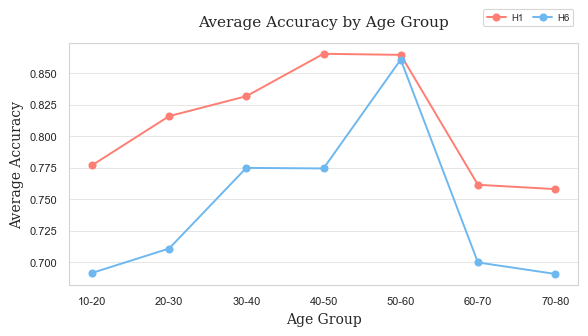

In [38]:
plot_age_group_accuracy(age_group_acc)

## gender

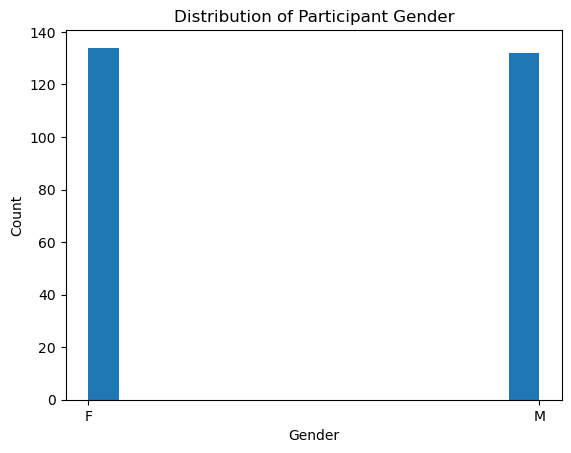

In [24]:
import matplotlib.pyplot as plt
subj_df["gender"] = subj_df["gender"].replace(-99, np.nan)
plt.hist(subj_df["gender"].dropna(), bins=15)
plt.xlabel("Gender")
plt.ylabel("Count")
plt.title("Distribution of Participant Gender")
plt.show()

In [25]:
gender_acc = subj_df.groupby("gender")[["acc_h1", "acc_h6"]].mean().reset_index()
print(gender_acc)

  gender    acc_h1    acc_h6
0      F  0.778015  0.703485
1      M  0.808860  0.707357


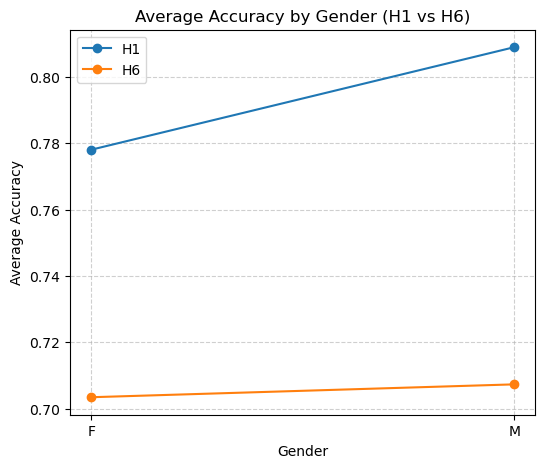

In [26]:

plt.figure(figsize=(6,5))

plt.plot(gender_acc["gender"], gender_acc["acc_h1"], marker="o", label="H1")
plt.plot(gender_acc["gender"], gender_acc["acc_h6"], marker="o", label="H6")

plt.xlabel("Gender")
plt.ylabel("Average Accuracy")
plt.title("Average Accuracy by Gender (H1 vs H6)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [27]:
from scipy.stats import pearsonr, spearmanr

gender_map = {"M": 0, "F": 1}
gender = subj_df["gender"].map(gender_map).astype(float)
delta = subj_df["delta_h6_h1"]

# mask out NaNs in gender
valid = gender.notna()
gender_valid = gender[valid]
delta_valid = delta[valid]

pearson_r, pearson_p = pearsonr(gender_valid, delta_valid)
spearman_r, spearman_p = spearmanr(gender_valid, delta_valid)

print(f"Pearson r={pearson_r:.3f}, p={pearson_p:.3f}")
print(f"Spearman r={spearman_r:.3f}, p={spearman_p:.3f}")

Pearson r=0.125, p=0.041
Spearman r=0.133, p=0.030


In [28]:
# Check total number of valid participants
n_total = len(subj_df)
n_valid_age = subj_df["age"].notna().sum()
n_valid_gender = subj_df["gender"].notna().sum()

print(f"Total participants: {n_total}")
print(f"With valid age info: {n_valid_age}")
print(f"With valid gender info: {n_valid_gender}")

Total participants: 277
With valid age info: 266
With valid gender info: 266


In [29]:
age_mean = subj_df["age"].mean()
age_sd = subj_df["age"].std()
age_min = subj_df["age"].min()
age_max = subj_df["age"].max()

print(f"Age range: {age_min:.0f}–{age_max:.0f}, Mean = {age_mean:.1f}, SD = {age_sd:.1f}")

Age range: 10–74, Mean = 27.2, SD = 17.2


In [30]:
gender_counts = subj_df["gender"].value_counts(dropna=True)
gender_percent = subj_df["gender"].value_counts(normalize=True, dropna=True) * 100

print("Gender counts:")
print(gender_counts)
print("Gender percentages:")
print(gender_percent.round(1))

Gender counts:
gender
F    134
M    132
Name: count, dtype: int64
Gender percentages:
gender
F    50.4
M    49.6
Name: proportion, dtype: float64


In [31]:
f"Data were collected from {n_total} participants (mean age = {age_mean:.1f} years, range = {age_min:.0f}–{age_max:.0f}), including {gender_counts.get(0, 0)} males and {gender_counts.get(1, 0)} females."


C:\Users\91486\AppData\Local\Temp\ipykernel_16124\2856400659.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"Data were collected from {n_total} participants (mean age = {age_mean:.1f} years, range = {age_min:.0f}–{age_max:.0f}), including {gender_counts.get(0, 0)} males and {gender_counts.get(1, 0)} females."


'Data were collected from 277 participants (mean age = 27.2 years, range = 10–74), including 134 males and 132 females.'